# Pairwise comparison of ratings

Testing different aspects of this approach to scoring readability

- sampling pairs of articles
- inference of the scores via Bradley-Terry model

## Imports

In [1]:
import bz2
import os
import re
import json
import pandas as pd
import networkx as nx
import numpy as np
import crowdkit
%load_ext autoreload
%autoreload 2

In [2]:
## plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Creating a random sample of pairs

- one requirement is to check that all articles are to each other at least via 1 comparison
- we test this by 

Summary: Graph with 10 nodes and 25 edges
Graph is fully connected. No more edges needed
Look at the network of comparisons:


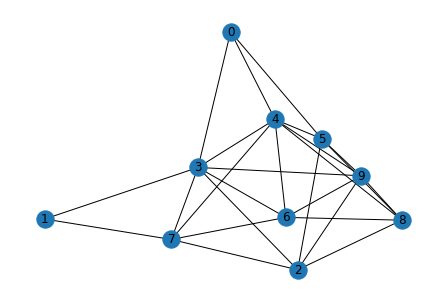

In [3]:
# define numbers
N = 10 # number of articles (nodes)
E = 25 # number of comparisons (undirected edges)

np.random.seed(1)
# create undirected graph with N nodes
list_add_nodes = []
for i in range(N):
    list_add_nodes += [i]
g = nx.Graph()
g.add_nodes_from(list_add_nodes)
# create E random edges 
# list of all potential edges that can be added (in random order after shuffling)
list_all_edges = list(nx.non_edges(g))
np.random.shuffle(list_all_edges)
list_add_edges = list_all_edges[:E]
g.add_edges_from(list_add_edges)
# Resulting Graph
print("Summary: %s"%g)

# calculate number of connected components
cc = nx.connected_components(g)
n_cc = sum([1 for c in cc])
if n_cc==1:
    print("Graph is fully connected. No more edges needed")
else:
    print("Graph is not fully connected. Try with more edges or choose a different seed.")
print("Look at the network of comparisons:")
nx.draw(g,with_labels=True)

# Inference

- how to get the scores from the set of comparisons
- we generate synthetic data according to the Bradley-Terry-model https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model

In [4]:
# parameters
N=100 # number of nodes
E=500 # number of pairs
sE=3 # number of times each pair is rated

### Draw synthetic data

In [5]:
def get_edges(N,E,seed=1):
    np.random.seed=seed
    list_add_nodes = []
    for i in range(N):
        list_add_nodes += [i]
    g = nx.Graph()
    g.add_nodes_from(list_add_nodes)
    # create E random edges 
    # list of all potential edges that can be added (in random order after shuffling)
    list_all_edges = list(nx.non_edges(g))
    np.random.shuffle(list_all_edges)
    list_add_edges = list_all_edges[:E]
    g.add_edges_from(list_add_edges)
    # calculate number of connected components
    cc = nx.connected_components(g)
    n_cc = sum([1 for c in cc])
    if n_cc==1:
        g_connected=True
    else:
        g_connected=False
    
    return list_add_edges, g_connected

In [6]:
# node gets a random readability score between 0 and 1
arr_theta = np.sort(np.random.random(size = N))[::-1]

list_edges, connected = get_edges(N,E)
print("Comparisons:", list_edges[:10])
print("Connected: ",connected)

Comparisons: [(50, 54), (1, 11), (37, 68), (10, 92), (64, 71), (35, 91), (5, 94), (44, 73), (26, 35), (63, 76)]
Connected:  True


In [13]:
# generate ratings
list_ratings = []
for e in list_edges:
    i = e[0]
    j = e[1]
    # number of times each pair gets compaired
    theta_i = arr_theta[i]
    theta_j = arr_theta[j]
    # probability that i "beats" j
    p_ij = theta_i/(theta_i+theta_j)
    for i_s in range(sE):
        p_r = np.random.random() # random number
        # i beats j
        if p_r<p_ij:
            winner = i
        # j beats i
        else:
            winner = j
        list_ratings += [(i,j,winner,i_s)]
print(list_ratings[:10])
# each entry is a single comparion consisting of a 4-tuple
# - first item in the comparison
# - second item in the comparison
# - item that won in the comparison
# - the "worker" (here it is the k-th comparison of the same pair)
            

[(50, 54, 50, 0), (50, 54, 50, 1), (50, 54, 50, 2), (1, 11, 11, 0), (1, 11, 1, 1), (1, 11, 1, 2), (37, 68, 37, 0), (37, 68, 37, 1), (37, 68, 37, 2), (10, 92, 10, 0)]


### inference via crowd-kit

In [8]:
from crowdkit.aggregation import BradleyTerry

In [9]:
# set up the dataframe according to example-notebook: https://github.com/Toloka/crowd-kit/blob/main/examples/Readability-Pairwise.ipynb
df=pd.DataFrame(list_ratings,columns=["left","right","label","worker"])
df

left  right  label  worker
0       50     54     54       0
1       50     54     54       1
2       50     54     50       2
3        1     11      1       0
4        1     11      1       1
...    ...    ...    ...     ...
1495    61     78     61       1
1496    61     78     61       2
1497     4     99      4       0
1498     4     99      4       1
1499     4     99      4       2

[1500 rows x 4 columns]

In [10]:
# run inference and get scores
agg_bt = BradleyTerry(n_iter=100).fit_predict(df)
arr_theta_inferred = agg_bt.values

# the inferred scores can be re-scaled arbitrarily
# lets normalize them so the highest score is 1.
arr_theta_inferred = arr_theta_inferred/np.max(arr_theta_inferred)

### compare true and inferred scores

Text(0, 0.5, 'Inferred score')

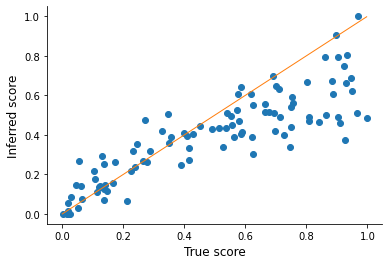

In [11]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(arr_theta,arr_theta_inferred,lw=0,marker='o')
plt.plot([0,max(arr_theta)],[0,max(arr_theta)],lw=1)
ax.set_xlabel("True score")
ax.set_ylabel("Inferred score")

In [12]:
### calculate correlation
from scipy.stats import spearmanr
corr=spearmanr(arr_theta,arr_theta_inferred)
print(corr)

SpearmanrResult(correlation=0.8621920853591336, pvalue=1.056237367365763e-30)
